In [13]:
from PIL import Image, ImageDraw, ImageFont

from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

In [2]:
feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang="rus")  # apply_ocr is set to True by default
tokenizer = LayoutLMv2TokenizerFast("vocab.txt")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

In [26]:
image = Image.open('../datasets/финансовые_доки/2НДФЛ/1.jpeg').convert("RGB")

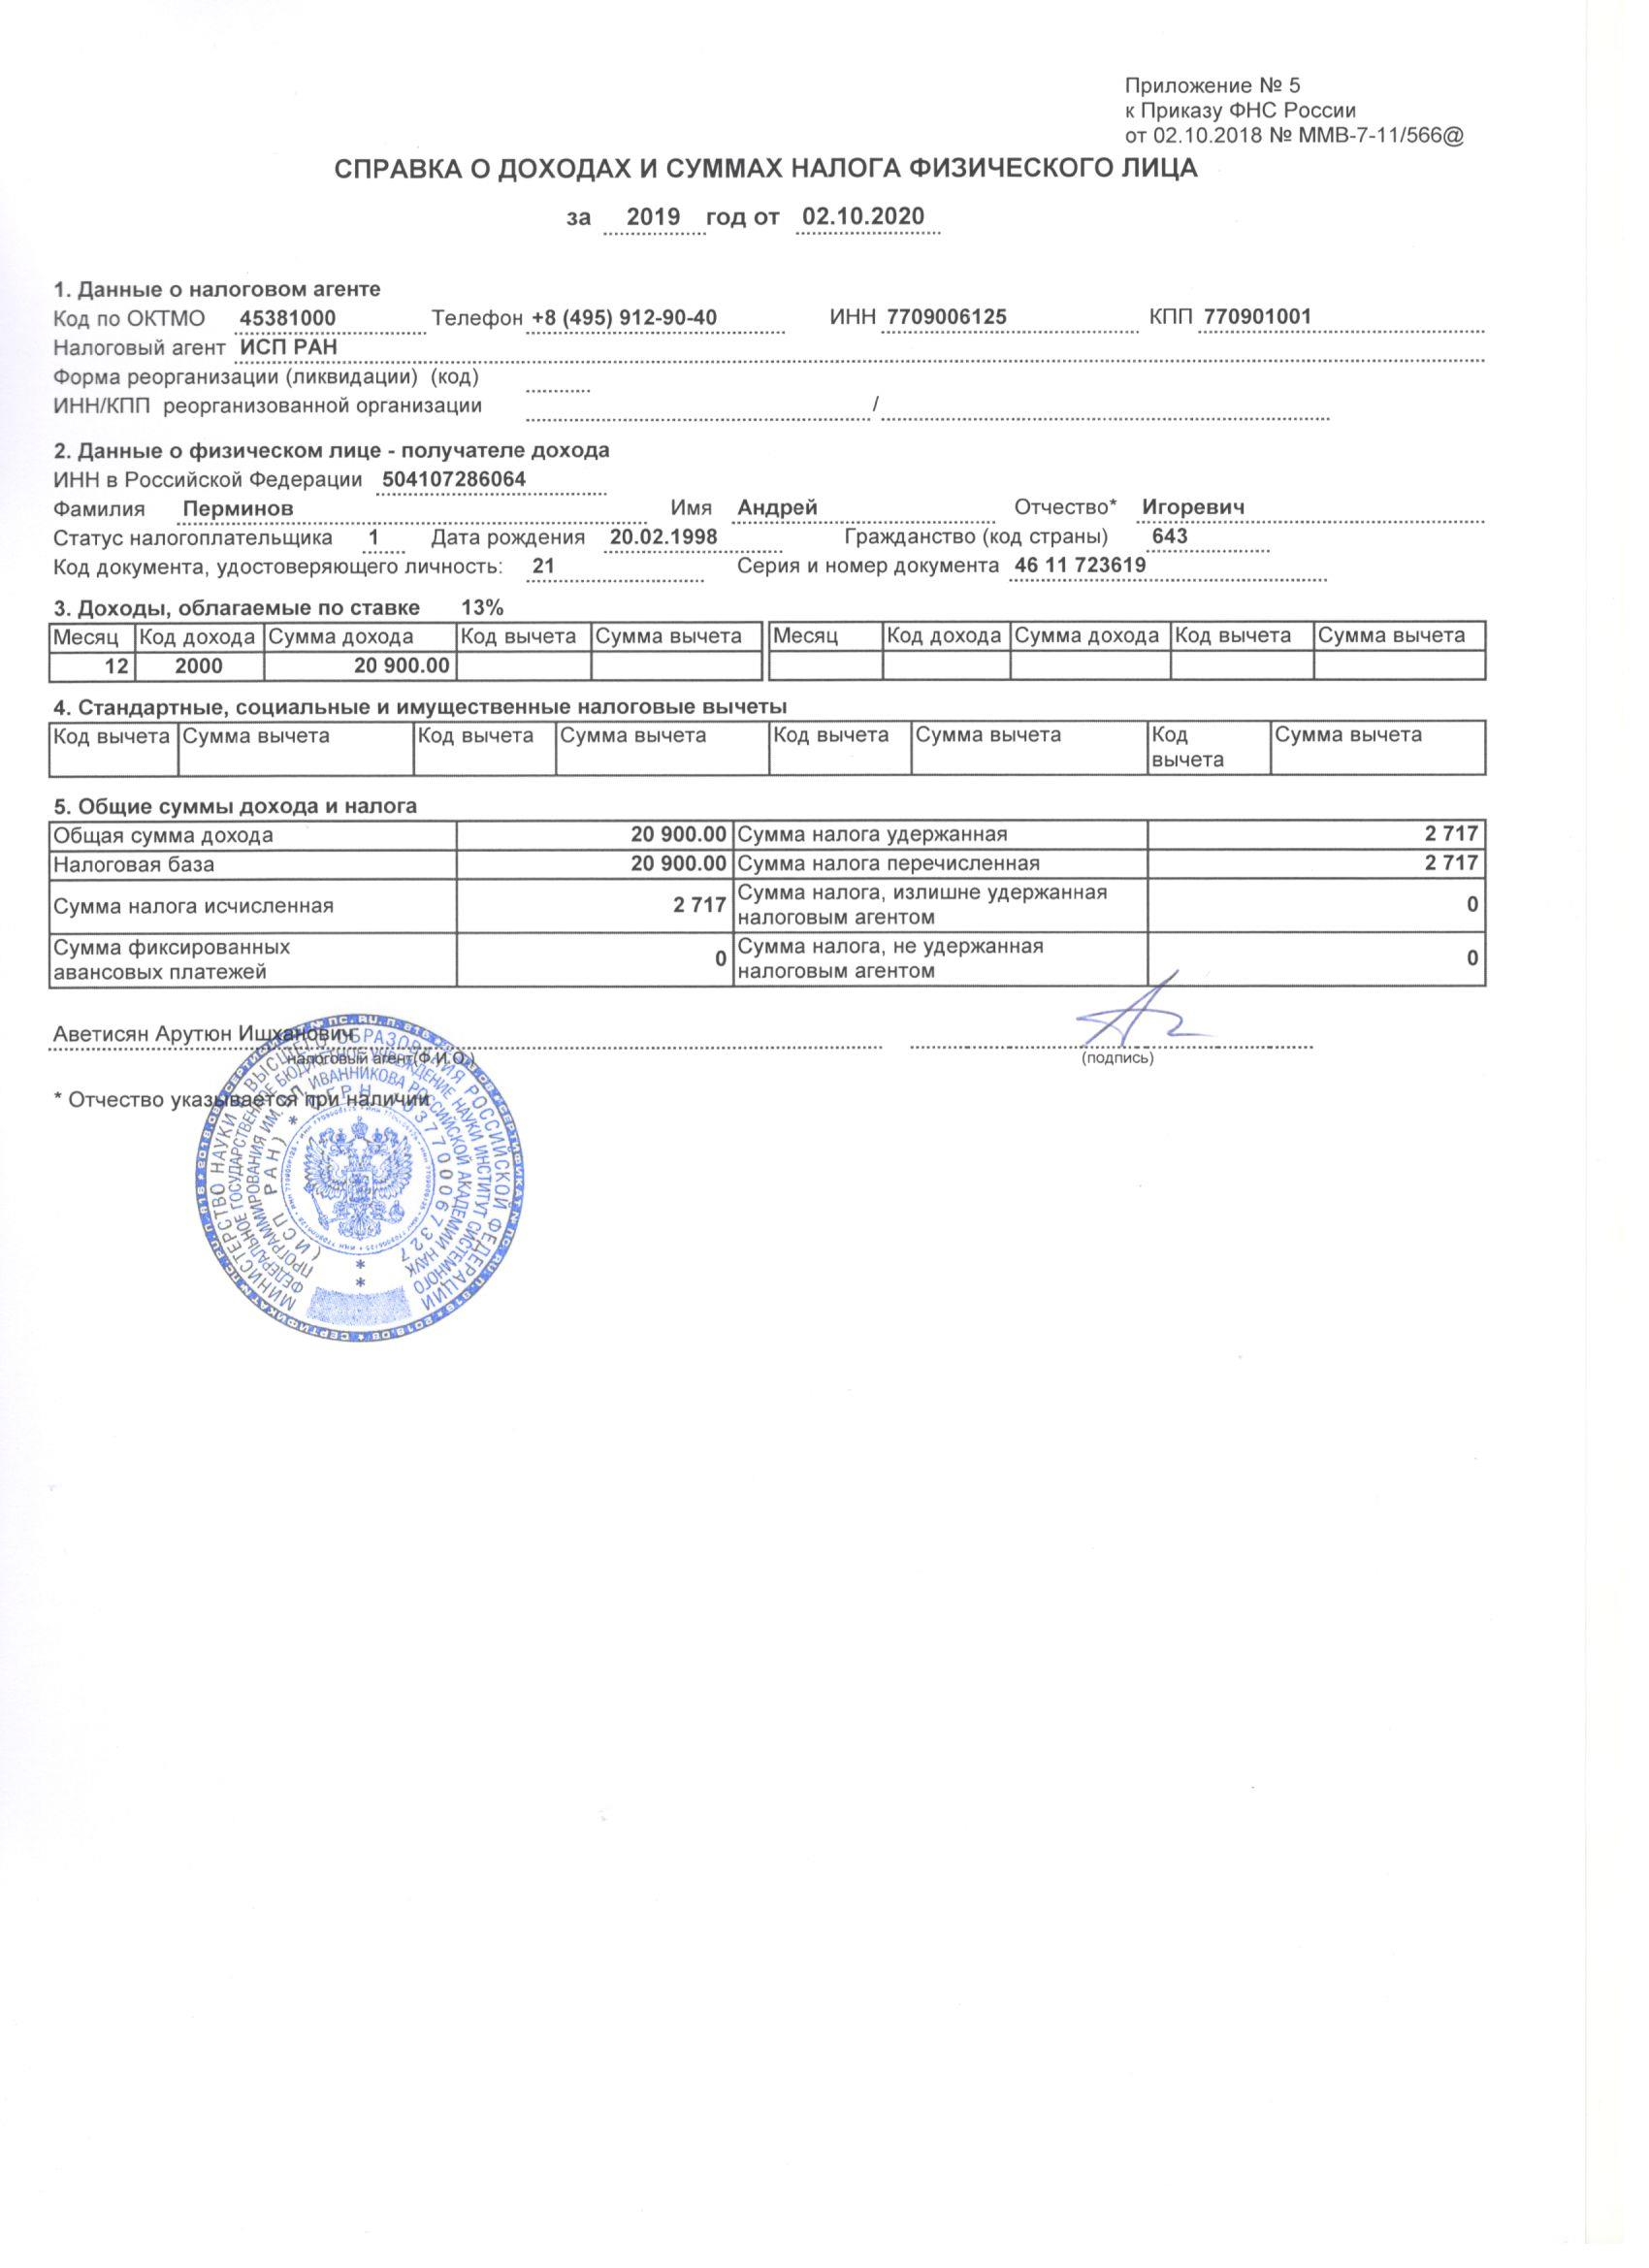

In [21]:
image

In [22]:
encoding = feature_extractor(image, return_tensors="pt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [25]:
width, height = image.size
draw = ImageDraw.Draw(image)

for box in encoding['boxes'][0]:
    box = unnormalize_box(box, width, height)
    draw.rectangle(box, outline=(255,0,0), width=2)

image

In [27]:
encoded_inputs = processor(
    image, padding="max_length", truncation=True, return_tensors="pt"
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoded_inputs.keys())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


In [31]:
processor.tokenizer.decode(encoded_inputs['input_ids'][0])

'[CLS] приложение № 5 к приказу фнс россии от 02. 10. 2018 № ммв - 7 - 11 / 566 @ справка о доходах и суммах налога физического лица за _ 2019 год от 02. 10. 2020 1. данные о налоговом агенте код по октмо — 45381000 телефон + 8 ( 495 ) 912 - 90 - 40 инн 7709006125 кпп 770901001 налоговыи агент [UNK] форма реорганизации ( ликвидации ) ( код ) инн / кпп реорганизованнои организации 2. данные о физическом лице - получателе дохода инн в россиискои федерации 504107286064 фамилия перм! статус налого код документа, удостоверяющего личность : отчество * код страны ) серия и номер документа 3. доходы, облагаемые по ставке 13 % месяц | код дохода [ сумма дохода месяц — [ код дохода [ сумма дохода [ код вычета ч2 [ 200 [ — 209009 [ г м оо 4. стандартные, социальные и имущественные налоговые вычеты код вычета | сумма вычета код вычета _ | сумма вычета код вычета | сумма вычета код сумма вычета вычета 5. общие суммы дохода и налога общая сумма дохода налоговая база сумма налога, излишне удержанная 

In [32]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/berkiu/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [33]:
from transformers import LayoutLMv2ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
model.to(device)

# forward pass
outputs = model(**encoded_inputs)
print(outputs.logits.shape)

torch.Size([1, 512, 7])


In [34]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

In [35]:
label2id = {'O': 0,
 'B-HEADER': 1,
 'I-HEADER': 2,
 'B-QUESTION': 3,
 'I-QUESTION': 4,
 'B-ANSWER': 5,
 'I-ANSWER': 6}

In [36]:
id2label = {0: 'O',
            1: 'B-HEADER',
            2: 'I-HEADER',
            3: 'B-QUESTION',
            4: 'I-QUESTION',
            5: 'B-ANSWER',
            6: 'I-ANSWER'}

In [37]:
true_predictions = [id2label[prediction] for prediction in predictions]
true_boxes = [unnormalize_box(box, width, height) for box in token_boxes]

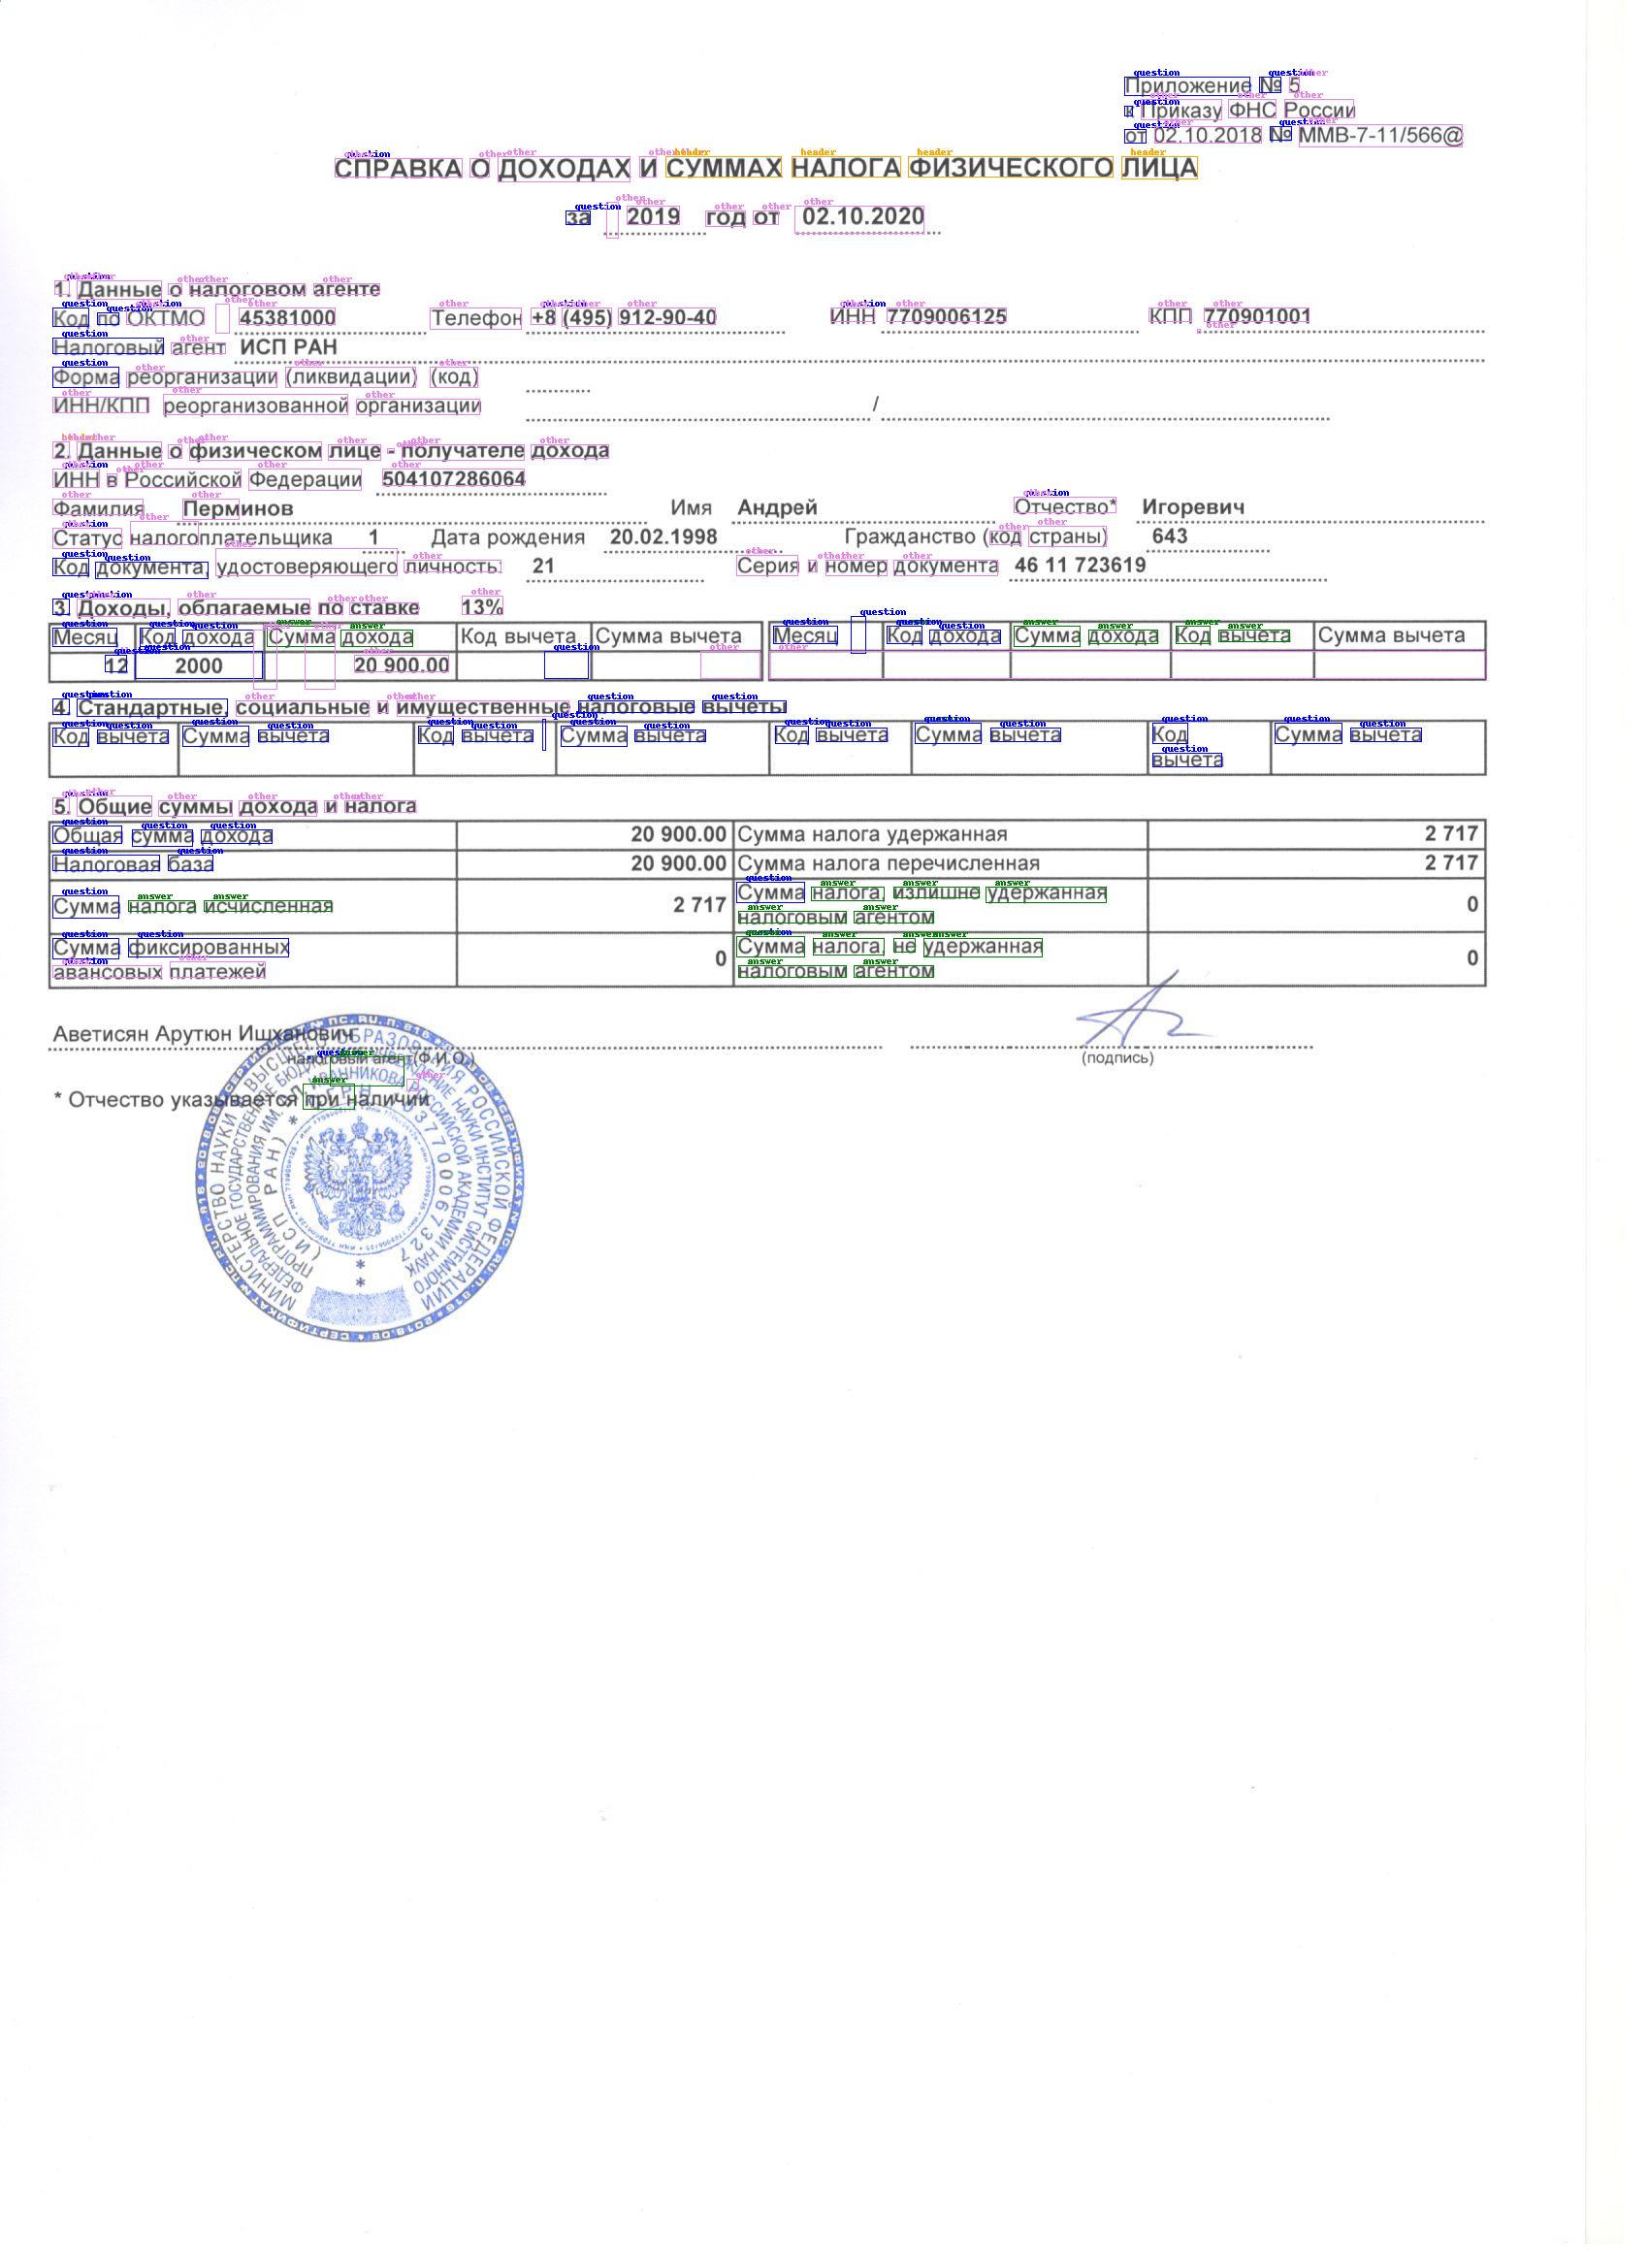

In [38]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [41]:
image.save('russian_res.jpg')